In [66]:
import pandas as pd
import pdb
import numpy as np
import itertools
from utils import *
from snakemake.io import expand
import yaml
import cerberus
import pyranges as pr
import upsetplot
import matplotlib.pyplot as plt
import itertools

In [3]:
config_file = 'workflow/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [155]:
species = 'human'
files_1_name = 'procap'
files_1 = expand(config['procap']['bed_format'],
                     pc_biosamp='k562',
                     pc_rep=[str(i) for i in range(1,7)],
                     pc_output=['bidirectional_peaks', 'unidirectional_peaks'],
                     species=species)
files_2_name = 'lr'
files_2 = expand(config['lr']['bed_format'],
                     lr_biosamp='k562',
                     lr_rep=['1', '2', '3'],
                     species=species)
files_3_name = 'ccre'
files_3 = expand(config['ccre']['bed_format'],
                       species='human',
                       ccre_type=['pls', )


In [156]:
files_1

['data/human/procap/k562_1_bidirectional_peaks_formatted.bed',
 'data/human/procap/k562_1_unidirectional_peaks_formatted.bed',
 'data/human/procap/k562_2_bidirectional_peaks_formatted.bed',
 'data/human/procap/k562_2_unidirectional_peaks_formatted.bed',
 'data/human/procap/k562_3_bidirectional_peaks_formatted.bed',
 'data/human/procap/k562_3_unidirectional_peaks_formatted.bed',
 'data/human/procap/k562_4_bidirectional_peaks_formatted.bed',
 'data/human/procap/k562_4_unidirectional_peaks_formatted.bed',
 'data/human/procap/k562_5_bidirectional_peaks_formatted.bed',
 'data/human/procap/k562_5_unidirectional_peaks_formatted.bed',
 'data/human/procap/k562_6_bidirectional_peaks_formatted.bed',
 'data/human/procap/k562_6_unidirectional_peaks_formatted.bed']

In [157]:
def three_way_intersect(f1,
                        f1_group,
                        f2,
                        f2_group,
                        f3,
                        f3_group):
    def make_unique_region_id(df):
        """
        Make a unique region ID for BED regions that don't 
        alread have unique identifiers
        """
        df['region_id'] = df['group_name']+'_'+\
                          df['Chromosome']+'_'+\
                          df['Start'].astype(str)+'_'+\
                          df['End'].astype(str)#+'_'+\
                          #df['Strand'].astype(str)
        df = df.drop_duplicates()
        return df
    
    def read_beds(files, name):
        df = pd.DataFrame()
        for f in files:
            temp = pd.read_csv(f, sep='\t')
            df = pd.concat([df, temp], axis=0)
            
            # retain just the identifying characteristics 
            # df = df[['Chromosome', 'Start', 'End', 'Strand']]
            df = df[['Chromosome', 'Start', 'End']]
        df['group_name']  = name
        df = make_unique_region_id(df)
        return df
    
    def intersect_thing(a, a_name,
                        b, b_name,
                        c, c_name):
        a_ids = a.region_id.unique().tolist()
        
        # make a-b and b-c comparisons
        ab_ids = a.join(b,
                        how=None, # none = inner
                        slack=0,
                        suffix='_other').df.region_id.unique().tolist()
        ac_ids = a.join(c,
                        how=None, # none = inner
                        slack=0,
                        suffix='other').df.region_id.unique()
        abc_ids = list(set(ab_ids)&set(ac_ids))
        ab_ids = list(set(ab_ids)-set(abc_ids))
        ac_ids = list(set(ac_ids)-set(abc_ids))
        a_ids = list(set(a_ids)-\
                     set(abc_ids)-\
                     set(ab_ids)-\
                     set(ac_ids))
        # make a table
        ids = a_ids+ab_ids+ac_ids+abc_ids
        support = [a_name for i in range(len(a_ids))]
        support += [f'{a_name},{b_name}' for i in range(len(ab_ids))]
        support += [f'{a_name},{c_name}' for i in range(len(ac_ids))]
        support += [f'{a_name},{b_name},{c_name}' for i in range(len(abc_ids))]
        df = pd.DataFrame()
        df['region_id'] = ids
        df['support'] = support
        return df
    
    # read in beds
    f1_df = read_beds(f1, 
                      f1_group)
    print(len(f1_df.index))
    f2_df = read_beds(f2, 
                      f2_group)
    f3_df = read_beds(f3,
                      f3_group)
    
    # perform intersections: 
    f1_pr = pr.PyRanges(f1_df)
    f2_pr = pr.PyRanges(f2_df)
    f3_pr = pr.PyRanges(f3_df)
    
    f1_pr.to_bed('test_bed_1.bed')
    f2_pr.to_bed('test_bed_2.bed')
    f3_pr.to_bed('test_bed_3.bed')
    
    
    
#     # using regions from 1 as a reference
#     df = intersect_thing(f1_pr,
#                          f1_group,
#                          f2_pr,
#                          f2_group,
#                          f3_pr, 
#                          f3_group)

    
#     return df

In [158]:
df = three_way_intersect(files_1,
                        files_1_name,
                        files_2,
                        files_2_name,
                        files_3,
                        files_3_name)

346043


In [159]:
# code largely stolen from here: https://github.com/asntech/intervene/blob/master/intervene/modules/upset/upset.py
weights = {}
input_files = ['test_bed_1.bed', 'test_bed_2.bed','test_bed_3.bed']
# input_files = ['a', 'b', 'c']
N=len(input_files)
truth_table = [x for x in itertools.product("01", repeat=N)][1:]
for t in truth_table:
    print()
    print(t)
    one_names = [input_files[i] for i in range(N) if t[i] =='1']
    zero_names = [input_files[i] for i in range(N) if t[i] =='0']
    ones = [pr.read_bed(input_files[i]) for i in range(N) if t[i] =='1']
    zeros = [pr.read_bed(input_files[i]) for i in range(N) if t[i] =='0']
    #report those entries in set A which do ovelap with other sets
    x = ones[0]
    # import pdb; pdb.set_trace()
    if len(ones) > 1:
        for bed in ones[1:]:
            print('here')
            # print(f'intersecting {x} with {bed}')
            x = x.overlap(bed,
                 how='first')
    #report those entries in set A which doesn't ovelap with other sets
    if len(zeros) > 0:
        #y = zeros[0]
        for bed in zeros[0:]:
            print('here2')
            # print(f'intersecting {x} with {bed}')
            # x = x.intersect(bed, v=True, **kwargs)
            x = x.overlap(bed,
                 how='first',
                 invert=True)
            
    # X = (x).count()
    X = len(x.df.index)
    
    temp = x.df
    n1 = len(temp.index)
    n2 = len(temp.ThickEnd.unique())
    if n1 != n2: import pdb; pdb.set_trace()
    
    
    weights[''.join(t)] = X


('0', '0', '1')
here2
here2

('0', '1', '0')
here2
here2

('0', '1', '1')
here
here2

('1', '0', '0')
here2
here2

('1', '0', '1')
here
here2

('1', '1', '0')
here
here2

('1', '1', '1')
here
here


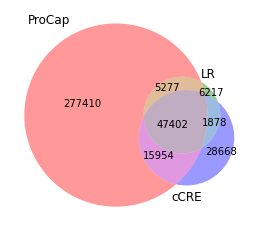

In [160]:
# all k562
venn3(weights, set_labels=['ProCap', 'LR', 'cCRE'])

In [152]:
for i in input_files:
    df = pr.read_bed(i).df
    print(len(df.index))

51240
16215
47532


In [148]:
df = pr.read_bed('data/human/lr/k562_1.bed').df
def make_unique_region_id(df):
        """
        Make a unique region ID for BED regions that don't 
        alread have unique identifiers
        """
        df['region_id'] = df['Chromosome'].astype(str)+'_'+\
                          df['Start'].astype(str)+'_'+\
                          df['End'].astype(str)#+'_'+\
                          #df['Strand'].astype(str)
        return df
df = make_unique_region_id(df)
df.loc[df.region_id.duplicated(keep=False)].sort_values(by='region_id')

,Chromosome,Start,End,Name,Score,Strand,ThickStart,ThickEnd,ItemRGB,BlockCount,region_id
11562,chr16,69187096,69187214,ENSG00000168807_1,.,+,"v40,v29,lapa,encode_cage,fantom_cage,pls",Known,ENSG00000168807,1,chr16_69187096_69187214
11687,chr16,69187096,69187214,ENSG00000260914_2,.,+,"lapa,encode_cage,fantom_cage,pls",Novel,ENSG00000260914,2,chr16_69187096_69187214
13199,chr18,36187446,36187547,ENSG00000134759_16,.,+,"lapa,encode_cage,fantom_cage,pls",Novel,ENSG00000134759,16,chr18_36187446_36187547
13153,chr18,36187446,36187547,ENSG00000075643_1,.,+,"v40,v29,lapa,gtex,encode_cage,fantom_cage,pls",Known,ENSG00000075643,1,chr18_36187446_36187547
14212,chr19,46787764,46787865,ENSG00000105281_4,.,-,"lapa,pls,pels",Novel,ENSG00000105281,4,chr19_46787764_46787865
14043,chr19,46787764,46787865,ENSG00000275719_1,.,+,"v40,v29,lapa,pls,pels",Known,ENSG00000275719,1,chr19_46787764_46787865
1294,chr1,159925440,159925557,ENSG00000158710_1,.,-,"v40,v29,lapa,gtex,encode_cage,fantom_cage,enco...",Known,ENSG00000158710,1,chr1_159925440_159925557
1537,chr1,159925440,159925557,ENSG00000213085_7,.,-,"lapa,gtex,encode_cage,fantom_cage,encode_rampa...",Novel,ENSG00000213085,7,chr1_159925440_159925557
15454,chr22,16601426,16601527,ENSG00000283633_3,.,+,"lapa,encode_cage,fantom_cage,encode_rampage,pels",Novel,ENSG00000283633,3,chr22_16601426_16601527
15281,chr22,16601426,16601527,ENSG00000100181_6,.,+,"lapa,encode_cage,fantom_cage,encode_rampage,pels",Novel,ENSG00000100181,6,chr22_16601426_16601527


In [142]:
df = pd.read_csv('data/human/lr/k562_1_formatted.bed', sep='\t')
print(len(df.index))
print(len(df.drop_duplicates().index))
df.head()

16228
16215


,Chromosome,Start,End,assay,biosample,rep,output
0,chr1,169794989,169795129,lr,k562,1,NaN
1,chr1,169794679,169794780,lr,k562,1,NaN
2,chr1,196651703,196652106,lr,k562,1,NaN
3,chr1,24415751,24415908,lr,k562,1,NaN
4,chr1,23019392,23019518,lr,k562,1,NaN


In [138]:
df = pr.read_bed('test_bed_2.bed').df
df.loc[df.ThickEnd.duplicated(keep=False)].sort_values(by='ThickEnd')

,Chromosome,Start,End,Name,Score,Strand,ThickStart,ThickEnd
11562,chr16,69187096,69187214,.,.,.,lr,lr_chr16_69187096_69187214
11687,chr16,69187096,69187214,.,.,.,lr,lr_chr16_69187096_69187214
13199,chr18,36187446,36187547,.,.,.,lr,lr_chr18_36187446_36187547
13153,chr18,36187446,36187547,.,.,.,lr,lr_chr18_36187446_36187547
14212,chr19,46787764,46787865,.,.,.,lr,lr_chr19_46787764_46787865
14043,chr19,46787764,46787865,.,.,.,lr,lr_chr19_46787764_46787865
1294,chr1,159925440,159925557,.,.,.,lr,lr_chr1_159925440_159925557
1537,chr1,159925440,159925557,.,.,.,lr,lr_chr1_159925440_159925557
15454,chr22,16601426,16601527,.,.,.,lr,lr_chr22_16601426_16601527
15281,chr22,16601426,16601527,.,.,.,lr,lr_chr22_16601426_16601527


In [ ]:
def get_lr_tss(ca_h5,
               det_mat,
               biosamp,
               biorep,
               ofile):

    # get tsss
    ca = cerberus.read(ca_h5)
    tss = ca.tss.copy(deep=True)

    # get det info
    df = pd.read_csv(det_mat, sep='\t')
    df = df.loc[(df.biosamp==biosamp)&(df.biorep.astype(int)==int(biorep))]
    df = df.drop(['biosamp', 'biorep'], axis=1).transpose()
    df.columns = ['temp']
    df = df.loc[df['temp']==True]
    tss_ids = df.index.tolist()

    # get bed file of det tsss
    tss = tss.loc[tss.Name.isin(tss_ids)]
    tss = pr.PyRanges(tss)
    tss.to_bed(ofile)

In [122]:
input_files

['test_bed_1.bed', 'test_bed_2.bed', 'test_bed_3.bed']

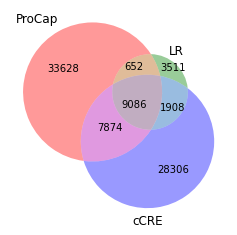

In [124]:
# a673 procap
venn3(weights, set_labels=['ProCap', 'LR', 'cCRE'])

In [125]:
3511+1908+652+9086 #lr

15157

In [126]:
7874+9086+19098+28306 # ccre

64364

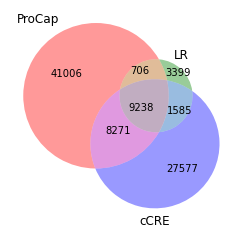

In [114]:
# mcf10a procap
venn3(weights, set_labels=['ProCap', 'LR', 'cCRE'])

In [127]:
706+3399+9238+1585#lr

14928

In [131]:
8271+9238+1585+27577# ccre

46671

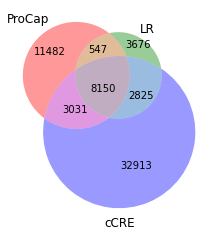

In [102]:
# k562 procap
venn3(weights, set_labels=['ProCap', 'LR', 'cCRE'])

In [132]:
547+3676+2825+8150# lr

15198

In [133]:
3031+8150+2825+32913 #ccre

46919

In [89]:
from matplotlib_venn import venn3


In [75]:
# def three_way_intersect(f1,
#                         f1_group,
#                         f2,
#                         f2_group,
#                         f3,
#                         f3_group):
#     def make_unique_region_id(df):
#         """
#         Make a unique region ID for BED regions that don't 
#         alread have unique identifiers
#         """
#         df['region_id'] = df['group_name']+'_'+\
#                           df['Chromosome']+'_'+\
#                           df['Start'].astype(str)+'_'+\
#                           df['End'].astype(str)#+'_'+\
#                           #df['Strand'].astype(str)
#         return df
    
#     def read_beds(files, name):
#         df = pd.DataFrame()
#         for f in files:
#             temp = pd.read_csv(f, sep='\t')
#             df = pd.concat([df, temp], axis=0)
            
#             # retain just the identifying characteristics 
#             # df = df[['Chromosome', 'Start', 'End', 'Strand']]
#             df = df[['Chromosome', 'Start', 'End']]
#         df['group_name']  = name
#         df = make_unique_region_id(df)
#         return df
    
#     def intersect_thing(a, a_name,
#                         b, b_name,
#                         c, c_name):
#         a_ids = a.region_id.unique().tolist()
#         b_ids = b.region_id.unique().tolist()
#         c_ids = c.region_id.unique().tolist()
        
#         # make a-b, a-c, and b-c comparisons
#         ab_ids = a.join(b,
#                         how=None, # none = inner
#                         slack=0,
#                         suffix='_other').df.region_id.unique().tolist()
#         ac_ids = a.join(c,
#                         how=None, # none = inner
#                         slack=0,
#                         suffix='other').df.region_id.unique()
#         bc_ids = b.join(c,
#                 how=None, # none = inner
#                 slack=0,
#                 suffix='other').df.region_id.unique()
        
#         # a ids
#         abc_ids = list(set(ab_ids)&set(ac_ids))
#         ab_ids = list(set(ab_ids)-set(abc_ids))
#         ac_ids = list(set(ac_ids)-set(abc_ids))
#         a_ids = list(set(a_ids)-\
#                      set(abc_ids)-\
#                      set(ab_ids)-\
#                      set(ac_ids))
        
#         # b ids
#         bc_ids = list(set(bc_ids)-set(abc_ids))
#         b_ids = list(set(b_ids)-\
#                      set(abc_ids)
        
        
#         # make a table
#         ids = a_ids+ab_ids+ac_ids+abc_ids
#         support = [a_name for i in range(len(a_ids))]
#         support += [f'{a_name},{b_name}' for i in range(len(ab_ids))]
#         support += [f'{a_name},{c_name}' for i in range(len(ac_ids))]
#         support += [f'{a_name},{b_name},{c_name}' for i in range(len(abc_ids))]
#         df = pd.DataFrame()
#         df['region_id'] = ids
#         df['support'] = support
#         return df
    
#     # read in beds
#     f1_df = read_beds(f1, 
#                       f1_group)
#     print(len(f1_df.index))
#     f2_df = read_beds(f2, 
#                       f2_group)
#     f3_df = read_beds(f3,
#                       f3_group)
    
#     # perform intersections: 
#     f1_pr = pr.PyRanges(f1_df)
#     f2_pr = pr.PyRanges(f2_df)
#     f3_pr = pr.PyRanges(f3_df)
    
#     # using regions from 1 as a reference
#     df = intersect_thing(f1_pr,
#                          f1_group,
#                          f2_pr,
#                          f2_group,
#                          f3_pr, 
#                          f3_group)

    
#     return df

In [63]:
print(len(df.index))

23210
